In [59]:
import os
import torch
from transformers import Trainer, TrainingArguments, AutoTokenizer, AutoModel, pipeline, AutoModelForSequenceClassification
import numpy as np
from datasets import Dataset, load_metric
import pandas as pd


## Getting AUC to run

In [10]:
roc_auc_score = load_metric("roc_auc", "multiclass")
refs = [1, 0, 1, 2, 2, 0]
pred_scores = [[0.3, 0.5, 0.2],
               [0.7, 0.2, 0.1],
               [0.005, 0.99, 0.005],
               [0.2, 0.3, 0.5],
               [0.1, 0.1, 0.8],
               [0.1, 0.7, 0.2]]
results = roc_auc_score.compute(references=refs, prediction_scores=pred_scores, multi_class='ovr')
print(round(results['roc_auc'], 2))

0.85


In [8]:
test_refs = pd.read_csv('labels.csv')
test_refs .drop('Unnamed: 0', axis = 1, inplace = True)

In [2]:
test_preds = pd.read_csv('logits.csv')
test_preds.drop(['Unnamed: 0', 'index'], axis=1 , inplace=True)

In [9]:
nPreds = test_preds.to_numpy()
nRefs = test_refs.to_numpy()

In [10]:
predictions = (nPreds == nPreds.max(axis=1)[:,None]).astype(int)

In [11]:
predictions

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0,

In [13]:
def compute_metrics(eval_pred):
    logits, refs = eval_pred 
    metric = load_metric("roc_auc", "multiclass")
    

    return metric.compute(references=refs, prediction_scores=logits, multi_class='ovr')

In [15]:
# eval_pred = [pred_scores, refs]
# eval_pred = [test_preds, test_refs]
eval_pred = [predictions, nRefs]

In [16]:
compute_metrics(eval_pred)

{'roc_auc': 0.6626208721036307}

In [4]:
print(metric.inputs_description)


Args:
- references (array-like of shape (n_samples,) or (n_samples, n_classes)): Ground truth labels. Expects different input based on use case:
    - binary: expects an array-like of shape (n_samples,)
    - multiclass: expects an array-like of shape (n_samples,)
    - multilabel: expects an array-like of shape (n_samples, n_classes)
- prediction_scores (array-like of shape (n_samples,) or (n_samples, n_classes)): Model predictions. Expects different inputs based on use case:
    - binary: expects an array-like of shape (n_samples,)
    - multiclass: expects an array-like of shape (n_samples, n_classes)
    - multilabel: expects an array-like of shape (n_samples, n_classes)
- average (`str`): Type of average, and is ignored in the binary use case. Defaults to 'macro'. Options are:
    - `'micro'`: Calculates metrics globally by considering each element of the label indicator matrix as a label. Only works with the multilabel use case.
    - `'macro'`: Calculate metrics for each label,

## CNN

In [1]:
import pandas as pd 
from keras.utils import to_categorical
from torch.nn.utils.rnn import pad_sequence


from keras.models import Model
from keras.layers import Input, Embedding
from keras.layers import Bidirectional, LSTM
from keras.layers import Dropout, Dense, Activation

import numpy as np



In [ ]:
target = 'label'
input_column = 'cleanText'

train_data = pd.read_csv('../../../Files/Submissions/train/train2.csv', sep='|') 
# valid_data = pd.read_pickle('../../../Files/Comments/train/val_split_comments.pickle')
test_data = pd.read_csv('../../../Files/Submissions/train/test2.csv', sep='|')

In [126]:
target = 'label'
input_column = 'cleanText'

train_data = pd.read_csv('../../../Files/Submissions/train/train1.csv', sep='|') 
# valid_data = pd.read_pickle('../../../Files/Comments/train/val_split_comments.pickle')
test_data = pd.read_csv('../../../Files/Submissions/train/test1.csv', sep='|')

In [127]:


# train_data = train_data[[target, input_column]]
# # valid_data = valid_data[[target, input_column]]
# test_data = test_data[[target, input_column]]

data = pd.concat([train_data, test_data])


train_instances = train_data[input_column].apply(str).apply(str.split)
train_labels = train_data[target]

# collect known word tokens and tags
wordset, labelset = set(), set()

# collect tags from all data, to prevent unseen labels
labelset.update(set(data[target]))

# get the vocabulary
for words in train_instances:
    wordset.update(set(words))

# map words and tags into ints
PAD = '-PAD-'
UNK = '-UNK-'
word2int = {word: i + 2 for i, word in enumerate(sorted(wordset))}
word2int[PAD] = 0  # special token for padding
word2int[UNK] = 1  # special token for unknown words
 
label2int = {label: i for i, label in enumerate(sorted(labelset))}
# inverted index to translate it back
int2label = {i:label for label, i in label2int.items()}


def convert2ints(instances):
    """
    function to apply the mapping to all words
    """
    result = []
    for words in instances:
        # replace words with int, 1 for unknown words
        word_ints = [word2int.get(word, 1) for word in words]
        result.append(word_ints)
    return result
                          
train_instances_int = convert2ints(train_instances)
train_labels_int = [label2int[label] for label in train_labels]

In [128]:
test_instances = test_data[input_column].apply(str).apply(str.split)
test_labels = test_data[target]

test_instances_int = convert2ints(test_instances)
test_labels_int = [label2int[label] for label in test_labels]

# convert dev data
# val_instances = valid_data[input_column].apply(str).apply(str.split)
# val_labels = valid_data[target]

# val_instances_int = convert2ints(val_instances)
# val_labels_int = [label2int[label] for label in val_labels]

In [129]:
from keras.utils import to_categorical

train_labels_1hot = to_categorical(train_labels_int, len(label2int))
test_labels_1hot = to_categorical(test_labels_int, len(label2int))
# val_labels_1hot = to_categorical(val_labels_int, len(label2int))

train_labels_1hot[0]

array([1., 0.], dtype=float32)

In [130]:
# compute 95th percentile of training sentence lengths
L = sorted(map(len, train_instances))
MAX_LENGTH = L[int(len(L)*0.95)]
print(MAX_LENGTH)

# apply padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_instances_int = pad_sequences(train_instances_int, padding='post', maxlen=MAX_LENGTH)
test_instances_int = pad_sequences(test_instances_int, padding='post', maxlen=MAX_LENGTH)
# val_instances_int = pad_sequences(val_instances_int, padding='post', maxlen=MAX_LENGTH)

print(train_instances[0], len(train_instances[0]))
print(train_instances_int[0], len(train_instances_int[0]))

67
['know', 'video', 'north', 'tower', 'hit', 'flight', '[', 'NUM', ']', 'hd'] 10
[4201 8334 5158 7857 3517 2884   27    2   28 3416    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0] 67


In [131]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers import GlobalMaxPooling1D, Dropout
from keras.layers.core import Dense, Activation
import numpy as np

# make it repeatable
np.random.seed(42)

# set parameters of matrices and convolution
embedding_dim = 128
nb_filter = 64
filter_length = 3
hidden_dims = 32
stride_length = 1

inputs = Input((MAX_LENGTH, ), 
               name='word_IDs')
embeddings = Embedding(len(word2int), 
                       embedding_dim, 
                       input_length=MAX_LENGTH)(inputs)
convolution = Conv1D(filters=nb_filter,  # Number of filters to use
                    kernel_size=filter_length, # n-gram range of each filter.
                    padding='same',  #valid: don't go off edge; same: use padding before applying filter
                    activation='relu',
                    strides=stride_length)(embeddings)
convolution2 = Activation(activation='tanh')(convolution)
pooling = GlobalMaxPooling1D()(convolution2)
dropout1 = Dropout(0.2)(pooling)
dense = Dense(hidden_dims, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(dense)
output = Dense(len(label2int), activation='softmax')(dropout2)

model = Model(inputs=[inputs], outputs=[output])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'AUC'])

# get alist of all the layers and their size
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_IDs (InputLayer)       [(None, 67)]              0         
                                                                 
 embedding_5 (Embedding)     (None, 67, 128)           1126016   
                                                                 
 conv1d_5 (Conv1D)           (None, 67, 64)            24640     
                                                                 
 activation_5 (Activation)   (None, 67, 64)            0         
                                                                 
 global_max_pooling1d_5 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                           

In [132]:
# batch size can have a huge effect on performance!
batch_size = 64
epochs = 9

history = model.fit(train_instances_int, train_labels_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    )
                   
# validation_data=(val_instances_int, val_labels_1hot
loss, accuracy, auc = model.evaluate(test_instances_int, test_labels_1hot,
                                batch_size=batch_size,
                                verbose=False)

print("\nTesting Accuracy:  {:.4f}".format(auc))

Epoch 1/9
46/46 [==============================] - 2s 17ms/step - loss: 0.5625 - accuracy: 0.7696 - auc: 0.8518
Epoch 2/9
46/46 [==============================] - 1s 17ms/step - loss: 0.2103 - accuracy: 0.9289 - auc: 0.9771
Epoch 3/9
46/46 [==============================] - 1s 17ms/step - loss: 0.0926 - accuracy: 0.9741 - auc: 0.9905
Epoch 4/9
46/46 [==============================] - 1s 17ms/step - loss: 0.0537 - accuracy: 0.9905 - auc: 0.9947
Epoch 5/9
46/46 [==============================] - 1s 16ms/step - loss: 0.0348 - accuracy: 0.9935 - auc: 0.9975
Epoch 6/9
46/46 [==============================] - 1s 17ms/step - loss: 0.0212 - accuracy: 0.9956 - auc: 0.9988
Epoch 7/9
46/46 [==============================] - 1s 21ms/step - loss: 0.0129 - accuracy: 0.9980 - auc: 0.9995
Epoch 8/9
46/46 [==============================] - 1s 23ms/step - loss: 0.0072 - accuracy: 0.9990 - auc: 0.9999
Epoch 9/9
46/46 [==============================] - 1s 18ms/step - loss: 0.0065 - accuracy: 0.9990 - auc:

In [133]:
results = model.predict(test_instances_int)

86/86 [==============================] - 0s 2ms/step


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import seaborn as sns
from sklearn import svm, datasets, metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score


In [49]:
def calc_roc_curve(y_test, y_score):
    n_classes = y_test.shape[1]
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    lw = 2

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

   
    return fpr, tpr, roc_auc, n_classes

In [33]:
def plot_results_b(y_test, y_pred, model, perf_class, classifier="2"):
    if classifier == "1":
        labels = {0: "Non-Covid", 1: "Covid"}
    elif classifier == "2":
        labels = {0: "Anti-Vaccine", 1: "Neutral", 2: "Pro-Vaccine"}
    fig = plt.figure(f"{model} Performance Evaluation", figsize=(8, 8))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(5, 4)
    font = {"weight": "bold"}
    fpr, tpr, roc_auc, n_classes = calc_roc_curve(y_test, y_pred)
    ax0 = fig.add_subplot(axgrid[0:3, :])

    ax0.set_title(f"Receiver Operating Characteristic (ROC) Curve for {model}", fontdict=font)
     # Plot all ROC curves
    # ax0.figure(figsize=(3,3))
    # ax0.figure(dpi=600)
    lw = 2

     # Plot all ROC curves
    ax0.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    ax0.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        ax0.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(labels[i], roc_auc[i]),
        )

    ax0.plot([0, 1], [0, 1], "k--", lw=lw)
    ax0.set_xlim([0.0, 1.0])
    ax0.set_ylim([0.0, 1.05])
    ax0.set_xlabel("False Positive Rate")
    ax0.set_ylabel("True Positive Rate")
   
    ax0.legend(loc="lower right")

    ax1 = fig.add_subplot(axgrid[3:, :2])
    ax1.set_title("Confusion Matrics", fontdict=font)
    y_score_max = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)
    y_score_label = np.argmax(y_score_max, axis=1)
    y_test_label = np.argmax(y_test, axis=1)
    df = pd.DataFrame(metrics.confusion_matrix(y_test_label, y_score_label))
    df2 = df.div(df.sum(axis=1), axis=0)
    ax1 = sns.heatmap(df2, annot=True)
    ax1.set(xlabel='Predicted', ylabel='Actual', xticklabels=labels.values(), yticklabels=labels.values())
    ax1.set_title("Confusion matrix", fontdict=font)

    ax2 = fig.add_subplot(axgrid[3:, 2:])
    acc = metrics.accuracy_score(y_test_label, y_score_label)
    f1 = metrics.f1_score(y_test_label, y_score_label, average='macro')
    roc_auc_m = metrics.roc_auc_score(y_test, y_score_max, multi_class='ovo')
    ax2.set_title("Performance Metrics", fontdict=font )
    ax2.text(0.23, 0.85, f"Model: {model}", fontdict=font)
    ax2.text(0.23, 0.75, f"Model Type: {perf_class}")
    ax2.text(0.18, 0.68, "--------------------------------------------------")
    ax2.text(0.23, 0.6, f"Accuracy is {round(acc, 3)}")
    ax2.text(0.23, 0.5, f"F1 is {round(f1,3)}")
    ax2.text(0.23, 0.4, f"ROC-AUC is {round(roc_auc_m, 3)}")
    ax2.text(0.18, 0.33, "---------------------------------------------------")
    # ax2.text(0.23, 0.25, "Label Legend: ", fontdict=font )
    
    # ax2.text(0.23, 0.15, "Class 0: Anti-Vaccine")
    # ax2.text(0.23, 0.05, "Class 1: Neutral / Noise")
    # ax2.text(0.23, -0.05, "Class 2: Pro-Vaccine")
  
    ax2.set_axis_off()

    fig.tight_layout()
    plt.show()

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (3).

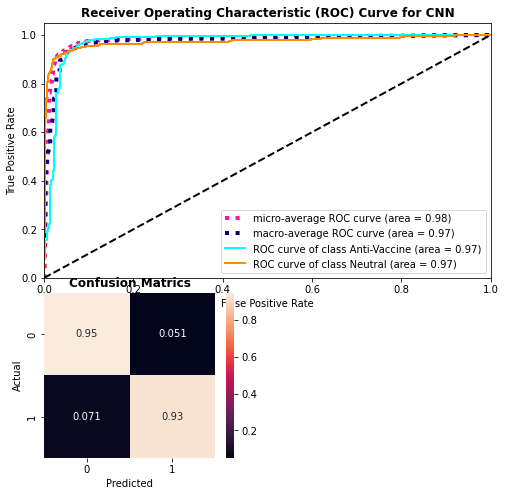

In [134]:
plot_results_b(test_labels_1hot, results, "CNN", "NN", classifier="2")

In [64]:
results_max = (results == results.max(axis=1)[:,None]).astype(int)
results_label = np.argmax(results_max, axis=1)

In [70]:
test_data_w = pd.concat([test_data, pd.Series(results_label)], axis=1)

In [76]:
test_data_w.rename(columns={0: "Predicted"}, inplace=True)

In [77]:
test_data_w.columns

Index(['id', 'text', 'url', 'score', 'title', 'author', 'selftext',
       'permalink', 'subreddit', 'created_utc', 'num_comments', 'label',
       'Comments', 'cleanText', 'Predicted'],
      dtype='object')

In [79]:
wrong = test_data_w[test_data_w["Predicted"] != test_data_w["label"]]

In [ ]:
wrong 

In [74]:
model.save('../../../Files/models/CNN8-64.h5')

In [135]:
results.tofile('../../../Files/models/cnn_C1_results.txt', sep=' ')